# ResNet18 Bone Age Prediction

## Library installation and modules imports
We uploaded on PyPi our own library containing the functions needed to define the models and preprocess the images, the ratio for this is to allow for a leaner structure and better redability of the notebook

In [ ]:
!pip install Human_Data_Analytics

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import os
import numpy as np
import random
import pandas as pd
import gc

#our library uploaded with pypi as a python package
from HDA.models.resnet18 import ResNet18
from HDA.preprocessing.image_pre_processing import data_generator_patch, plot_processed_image

from tensorflow.keras.optimizers import Adam

#Setting the seed
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

## Model and splits definition
Here we define the model, the used hyperparameters and the splits to be use in our pipeline

In [ ]:
network_type = 'channel_attention' # possible types: 'vanilla', 'cbam', 'channel_attention'
lr = 0.0005
batch_size = 40
train_samples = 16e3
num_patches_per_side = 5
crop_list = {'top': 0.05, 'bottom': 0.05, 'left': 0.05, 'right': 0.05}
augmentations = [0,4] # 0: flip, 1: rotation, 2: zoom, 3:blur, 4:identity
prob = [1/len(augmentations)]*len(augmentations) #probability for each possible data augmentation type
total_num_patches = num_patches_per_side ** 2

In [ ]:
# Input image shape (example: 224x224 RGB image)
input_shape = (224, 224, 3)
gender_input_shape = (1,)  # Assuming a scalar for gender input

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    optimizer = Adam(learning_rate=lr)
    model = ResNet18(input_shape, gender_input_shape, classes='regression', network_type=network_type)
    model.compile(optimizer=optimizer, loss='mse', metrics = [tf.keras.losses.MeanAbsoluteError()])

# Display model architecture
model.summary()

Number of devices: 2


Model: "ResNet18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_4[0][0]  

 Total params: 11,191,473 (42.69 MB)

 Trainable params: 11,181,873 (42.66 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [ ]:
train_path = "/kaggle/input/dataset-boneage/train"
val_path = "/kaggle/input/dataset-boneage/val"
save_path = os.path.join("/kaggle/working/", f"ResNet18_{network_type}.h5")

In [ ]:
extracted_files = os.listdir(os.path.join(train_path, 'images'))
num_train_images=len(extracted_files)
print("Number of training images:", num_train_images)
del extracted_files
gc.collect()

Number of training images: 12611


14

In [ ]:
# Create a Dataset from the generator
labels_training = pd.read_csv(os.path.join(train_path, 'labels.csv'))
labels_training_age = labels_training['Bone Age (months)'].to_list()
gender_training = labels_training['male'].apply(lambda x: 1 if x == True else 0).to_list() # True if male and False if female

preprocessed_images_train = tf.data.Dataset.from_generator(
    lambda: data_generator_patch(os.path.join(train_path, 'images'),
                           gender_training,
                           labels_training_age, admissible_augmentations = augmentations, prob = prob, num_patches_per_side = num_patches_per_side,
                                crop_list = crop_list),
    output_signature=(
        (tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name="image"),  # Input shape
        tf.TensorSpec(shape=(), dtype=tf.float32, name="gender")),   # Gender shape
        tf.TensorSpec(shape=(), dtype=tf.float32, name="label")   # Target shape
    )
)

preprocessed_images_train = preprocessed_images_train.repeat()
preprocessed_images_train = preprocessed_images_train.batch(batch_size)
training_dataset = preprocessed_images_train.prefetch(tf.data.AUTOTUNE)
print('batch_size:', batch_size)

batch_size: 40


In [ ]:
extracted_files = os.listdir(os.path.join(val_path, 'images'))
num_val_images=len(extracted_files)
print("Number of validation images:", num_val_images)
del extracted_files
gc.collect()

Number of validation images: 1425


0

In [ ]:
labels_val = pd.read_csv(os.path.join(val_path, 'labels.csv'))
labels_val_age = labels_val['Bone Age (months)'].to_list()
gender_val = labels_val['male'].apply(lambda x: 1 if x == True else 0).to_list()

preprocessed_images_val = tf.data.Dataset.from_generator(
    lambda: data_generator_patch(os.path.join(val_path, "images"),
                                 gender_val,
                                 labels_val_age, 
                                 train = False, 
                                 num_patches_per_side = num_patches_per_side,
                                 crop_list = crop_list),
    output_signature=(
        (tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name="image"),  # Input shape
        tf.TensorSpec(shape=(), dtype=tf.float32, name="gender")),   # Gender shape
        tf.TensorSpec(shape=(), dtype=tf.float32, name="label")   # Target shape
    )
)

# Optionally, you can shuffle and prefetch for performance
preprocessed_images_val = preprocessed_images_val.repeat()
preprocessed_images_val = preprocessed_images_val.batch(total_num_patches)
val_dataset = preprocessed_images_val.prefetch(tf.data.AUTOTUNE)

### Preprocess and Augmentations
Here we show an example of the results of our preprocessing pipeline. The images are first resized, cropped and CLAHE is applied, they are then splitted in 25 overlapping patch, 5 by each side of the image.
\
The patches are then augment with random flip(vetical or horizontal), rotation(|angle| <= 30), gaussian blur(sigma between 0.4 and 2.5) or identity

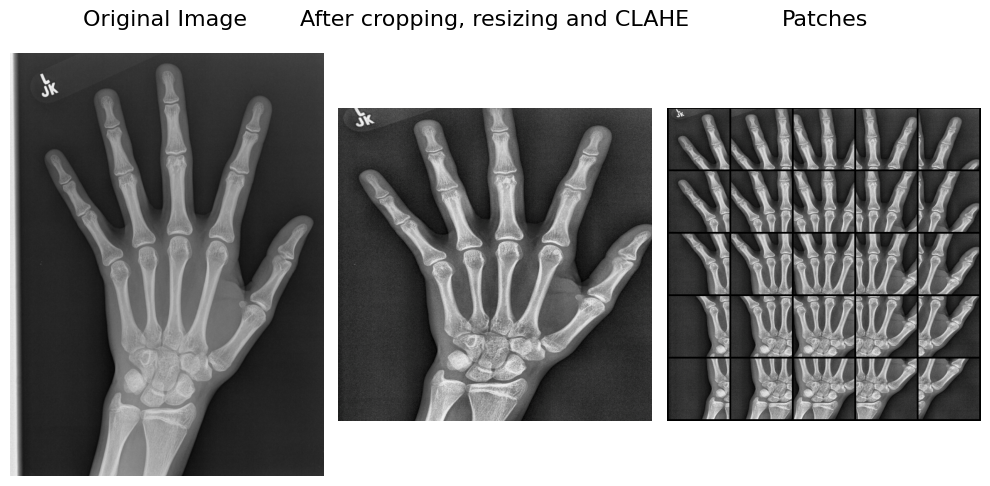

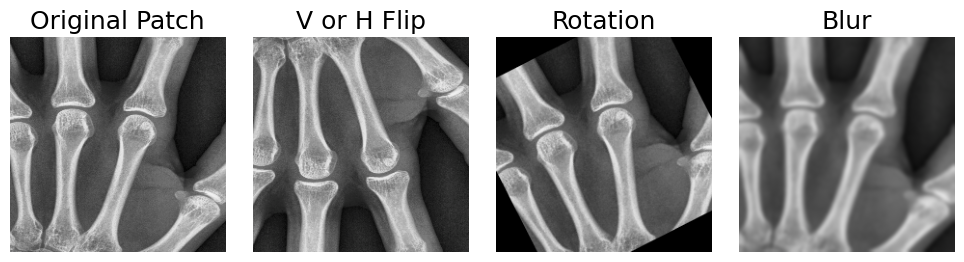

In [ ]:
plot_processed_image(os.path.join(train_path, 'images'), train=True, num_patches_per_side=num_patches_per_side, fontsize=[16])

## Training

In [ ]:
train_steps = int(np.ceil(train_samples/batch_size))
val_steps = int(np.ceil(len(labels_val_age)))

In [ ]:
# Create a callback for early stopping
callback = EarlyStopping(monitor='val_loss', 
                         mode='min',
                         patience=15, 
                         restore_best_weights=True)

history = model.fit(
    training_dataset,
    validation_data=val_dataset,
    epochs=50,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    batch_size=batch_size,
    callbacks=[callback]
)

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 902s 2s/step - loss: 9772.2393 - mean_absolute_error: 88.0464 - val_loss: 2286.7617 - val_mean_absolute_error: 40.6420
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 768s 2s/step - loss: 1788.4913 - mean_absolute_error: 34.8186 - val_loss: 2251.1108 - val_mean_absolute_error: 37.3536
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 756s 2s/step - loss: 1605.3296 - mean_absolute_error: 32.5509 - val_loss: 1713.7905 - val_mean_absolute_error: 34.8217
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 752s 2s/step - loss: 1510.6099 - mean_absolute_error: 31.5110 - val_loss: 1579.7769 - val_mean_absolute_error: 31.0050
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 745s 2s/step - loss: 1327.3564 - mean_absolute_error: 28.9832 - val_loss: 2065.2148 - val_mean_absolute_error: 37.4755
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 742s 2s/step - loss: 1102.7764 - mean_absolute_error: 25.9266 - val_loss: 2197.8147 - val_mean_absolute_error: 39.2321
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 740s 2

In [ ]:
#We save the model
model.save(save_path)

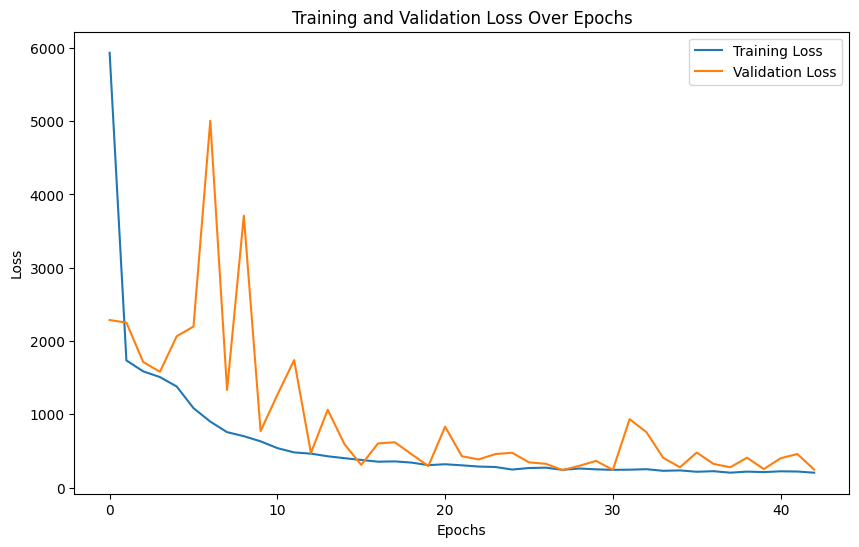

In [ ]:
import matplotlib.pyplot as plt

# Extract loss values for each epoch
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()